In [7]:
## Cell for global constants

# Constants
E_b = 1000.0 # Pa
E_c = 10000.0 # Pa
E_s = 10000.0 # Pa
h_b = 1e-4 # m
h_c = 1e-5 # m
gamma = 0.004 # N/m

hb_hc_ratio = h_b / h_c 
Eb_Ec_ratio = E_b / E_c
Es_Ec_ratio = E_s / E_c
non_linear_prefactor = 9 * Eb_Ec_ratio * (hb_hc_ratio)**(1/3) 
f_el_prefactor = 3 * Es_Ec_ratio * (hb_hc_ratio)**(1/3)

In [8]:
gamma_c = h_c * (E_c * E_s / 3)**(1/3)

print(gamma / gamma_c)
print(non_linear_prefactor)
print(f_el_prefactor)

1.2428930023815437
1.9389912210286955
6.463304070095651


![title](equations.jpg)

![title](tgdl.jpg)

![title](first_order_semi_implicit.jpg)

[ 0.          0.19634954  0.39269908 ... -0.58904862 -0.39269908
 -0.19634954]


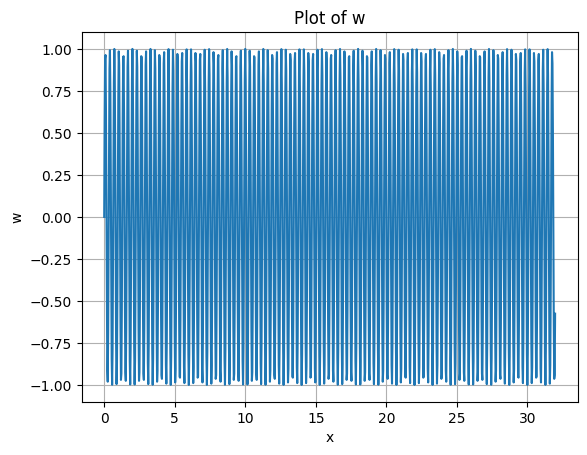

[ 1.45847931e-13 -3.99650182e-14  4.46222392e-13 ...  1.01422195e-12
  4.46222392e-13 -3.99650182e-14]


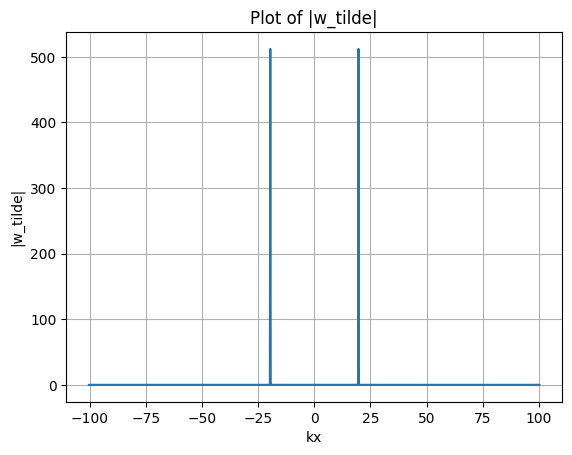

In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

total_time = 5.0
Nx = 1024
Ny = 1024
Lx = 32.0
Ly = 32.0
dt = 0.01
dx = Lx / Nx

x = np.linspace(0, Lx, Nx, endpoint=False)
kx = 2 * np.pi * fftfreq(Nx, d=dx)

print(kx)
w = np.sin(2*np.pi*x*100/32)

w_tilde = fft(w)

plt.plot(x, w)
plt.xlabel('x')
plt.ylabel('w')
plt.title('Plot of w')
plt.grid(True)
plt.show()

print(w_tilde.real)

plt.plot(kx, np.abs(w_tilde))
plt.xlabel('kx')
plt.ylabel('|w_tilde|')
plt.title('Plot of |w_tilde|')
plt.grid(True)
plt.show()


## Linear Part

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


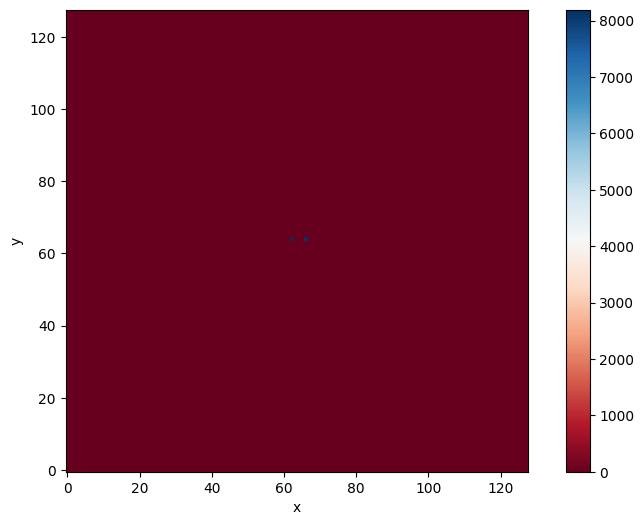

<Figure size 640x480 with 0 Axes>

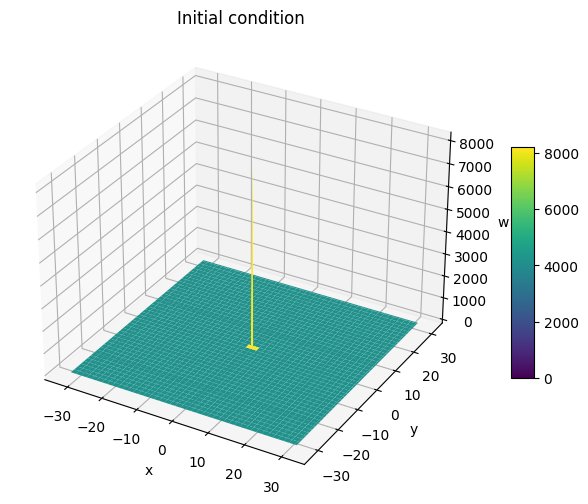

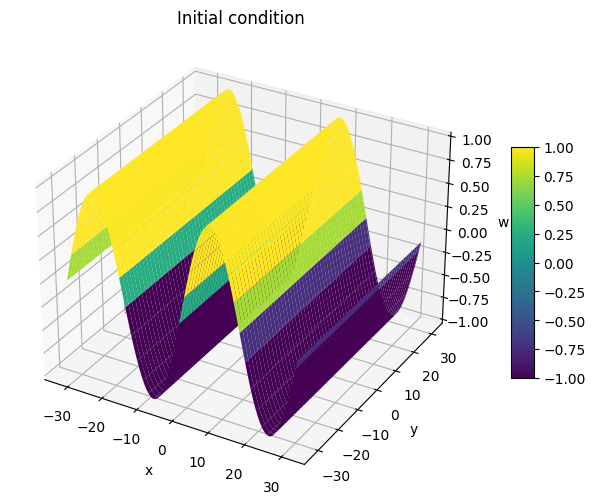

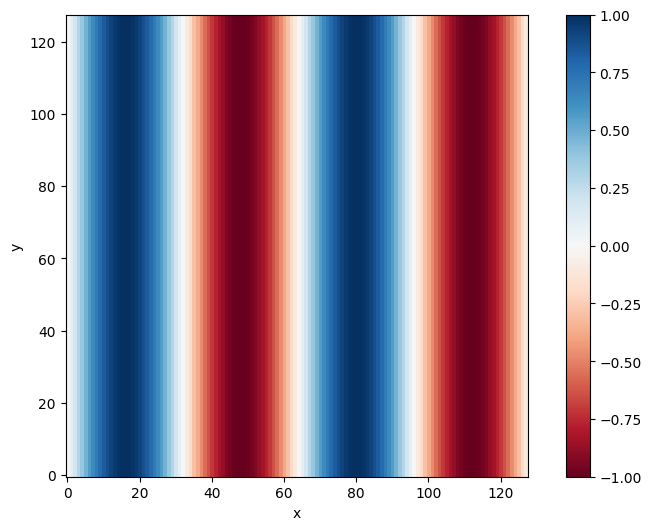

<Figure size 640x480 with 0 Axes>

In [23]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq

np.random.seed(69)

def initialize_grid(total_time = 5.0, Nx = 128, Ny = 128, Lx = 32.0, Ly = 32.0, dt = 0.01):
    # Parameters for the domain

    dx, dy = Lx/Nx, Ly/Ny   # Grid spacing
    steps = int(total_time / dt)

    # Create spatial grid
    x = np.linspace(0, Lx, Nx, endpoint=False)
    y = np.linspace(0, Ly, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y)

    # Wavenumber grids in Fourier space
    kx = 2 * np.pi * fftfreq(Nx, d=dx)
    ky = 2 * np.pi * fftfreq(Ny, d=dy)
    KX, KY = np.meshgrid(kx, ky)

    K_squared = KX**2 + KY**2
    K = np.sqrt(K_squared)
    K_fourth = K_squared**2

    # Handling division by zero at k=0
    K[K == 0] = 1e-10

    return Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth

Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth = initialize_grid(50)

# Function to explicitly enforce periodic boundary conditions
def enforce_periodic_boundary_conditions(w, u1, u2):
    # Enforce periodic boundary in x-direction (left matches right)
    w[0, :] = w[-1, :]
    u1[0, :] = u1[-1, :]
    u2[0, :] = u2[-1, :]
    # Enforce periodic boundary in y-direction (top matches bottom)
    w[:, 0] = w[:, -1]
    u1[:, 0] = u1[:, -1]
    u2[:, 0] = u2[:, -1]

    return w, u1, u2

# Initialize the displacement fields

w = np.random.randn(Nx, Ny) * 0.1  # Initial perturbation for w
u1 = np.zeros((Nx, Ny))             # Initial displacement in x direction
u2 = np.zeros((Nx, Ny))             # Initial displacement in y direction
w_values = []                       # List to store the value of w at (10,10) over time
w_values_2 = []

#w, u1, u2 = enforce_periodic_boundary_conditions(w, u1, u2)

def fft_transform(field):
    return fft2(field)

def ifft_transform(field_tilde):
    return np.real(ifft2(field_tilde))

def linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde):

    w_tilde_new = w_tilde / (1 + dt * (K_fourth - gamma * K_squared))
    u1_tilde_new = u1_tilde
    u2_tilde_new = u2_tilde
    return w_tilde_new, u1_tilde_new, u2_tilde_new

def plot_3d(x, y, z, title):
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surface = ax.plot_surface(x, y, z, cmap='viridis', vmin=-0.2, vmax=0.2)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('w')
    
    # Set the limits for the z-axis to keep the scale constant
    #ax.set_zlim(-0.2, 0.2)

    # Add a colorbar
    mappable = plt.cm.ScalarMappable(cmap='viridis')
    mappable.set_array(z)
    plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
    
    # Show the plot
    plt.show()

def plot_2d(X, Y, z):

    fig = plt.figure(figsize=(10, 6))
    plt.imshow(z, origin='lower', cmap='RdBu')
    #plt.grid(True)
    plt.colorbar()
    #plt.title(f'Time: {step * dt:.2f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.pause(0.1)
    plt.clf()
    plt.show()



#w = u1 = np.ones((Nx, Ny))  #+ np.random.uniform(0, 1, X.shape) # Initial condition for w
w = np.sin(2*np.pi*X/32)
w_tilde_initial = np.fft.fftshift(np.fft.fft2(w))
# plt.imshow(np.log(np.abs(w_tilde_initial) + 1))
# print(np.log(np.abs(w_tilde_initial) + 1))

# print(w[0,0])
# print(w_tilde_initial[0].imag)

# plt.figure()
print(np.abs(w_tilde_initial))
plot_2d(X, Y, np.abs(w_tilde_initial))
plot_3d(X, Y, np.abs(w_tilde_initial), 'Initial condition')
plot_3d(X, Y, w, 'Initial condition')
plot_2d(X, Y, w)


# plt.figure()

# # Perform 2D Fourier Transform and shift zero-frequency component to the center
# fft_data = np.fft.fftshift(np.fft.fft2(w))

# # Compute magnitude of Fourier coefficients
# fft_magnitude = np.abs(fft_data)

# # Plot the original image and its Fourier Transform
# fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# # Fourier Transform (Magnitude)
# ax[1].imshow(np.log(fft_magnitude + 1), cmap='inferno')
# ax[1].set_title('Fourier Transform (Fourier Space)')
# ax[1].axis('off')

# plt.show()
# Time stepping loop
# for step in range(steps):
    
#     # Fourier transform of w
#     w_tilde = fft_transform(w)
#     u1_tilde = fft_transform(u1)
#     u2_tilde = fft_transform(u2)

#     w_tilde_new, u1_tilde_new, u2_tilde_new = linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    
#     # Inverse Fourier transform to get updated w in real space
#     w = ifft_transform(w_tilde_new)
#     u1 = ifft_transform(u1_tilde_new)
#     u2 = ifft_transform(u2_tilde_new)
    
    # Store the value of w at (10,10) for visualization
    # if step % 100 == 0:
    #     w_values.append(math.log(w_tilde_new[15, 15]))
    #     w_values_2.append(math.log(w_tilde_new[1, 1]))


    # Visualization (every 1000 steps)
    # if step % 1000 == 0:

    #     plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
    #     plot_2d(X, Y, w)

# plt.figure(figsize=(10, 6))
# plt.plot(range(0, steps, 100), w_values, marker='o')
# plt.title('Value of w at (10,10) over time')
# plt.xlabel('Time step')
# plt.ylabel('w(0,0)')
# plt.grid(True)
# plt.show()

# # Fit a linear model to the data
# coefficients = np.polyfit(range(0, steps, 100), w_values, 1)
# slope = coefficients[0]

# print(f"The slope of the graph of 10 10 is: {slope}")

# # Fit a linear model to the data
# coefficients = np.polyfit(range(0, steps, 100), w_values_2, 1)
# slope = coefficients[0]

# print(f"The slope of the graph 6 6 is: {slope}")

# plt.figure(figsize=(10, 6))
# plt.plot(range(0, steps, 100), w_values_2, marker='o')
# plt.title('Value of w at (10,10) over time')
# plt.xlabel('Time step')
# plt.ylabel('w(0,0)')
# plt.grid(True)
# plt.show()

## F_el

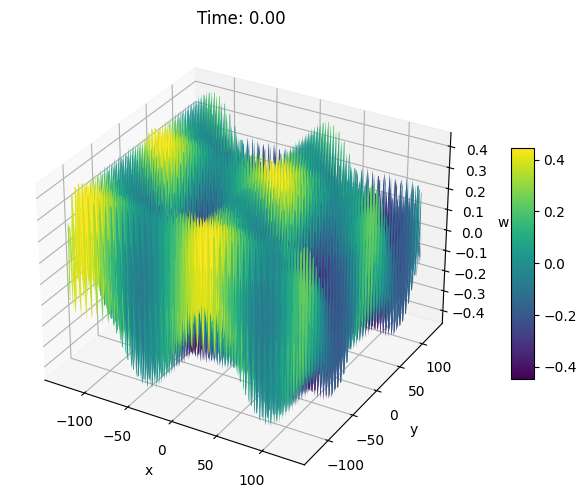

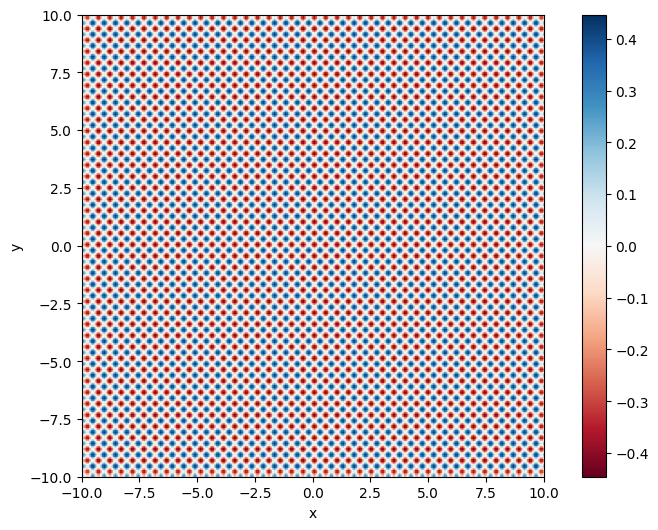

<Figure size 640x480 with 0 Axes>

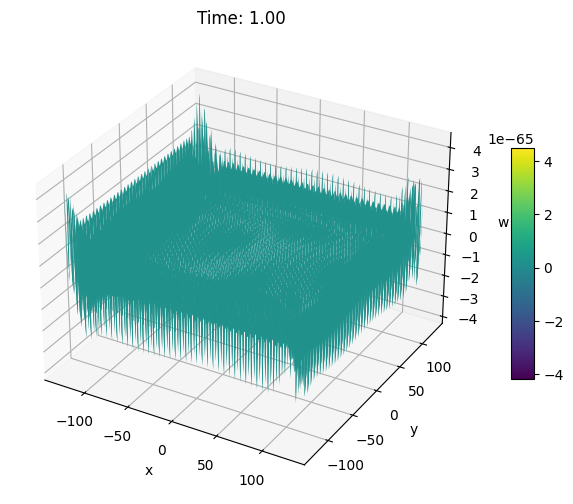

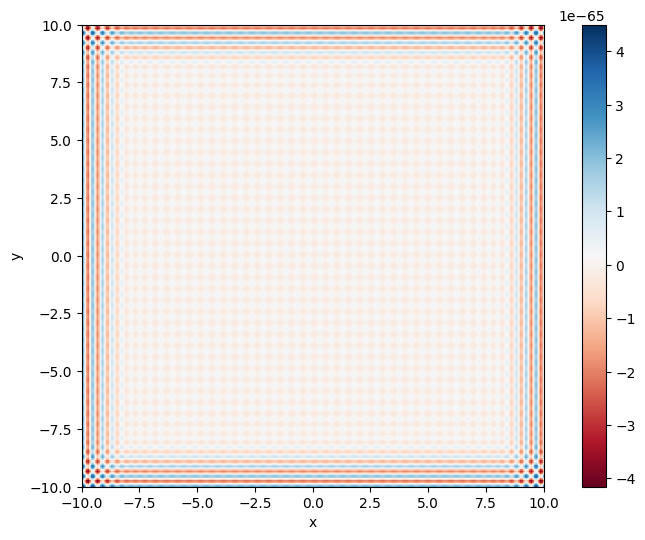

<Figure size 640x480 with 0 Axes>

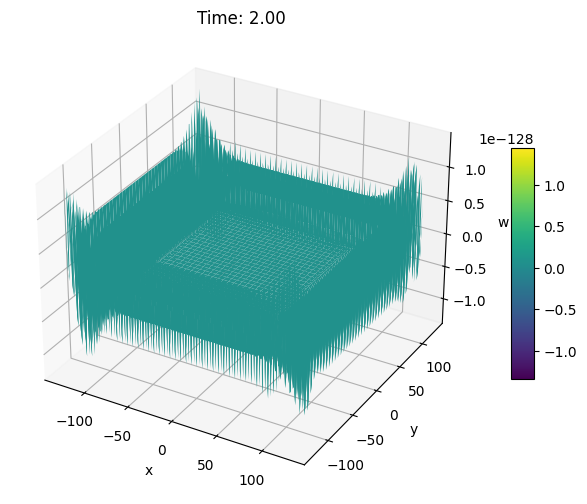

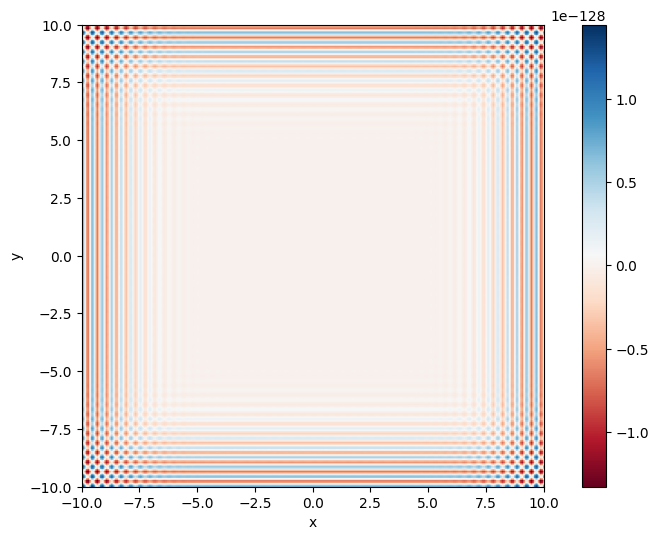

<Figure size 640x480 with 0 Axes>

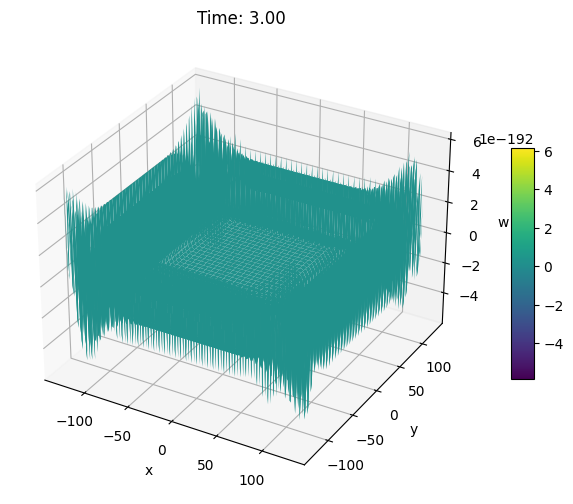

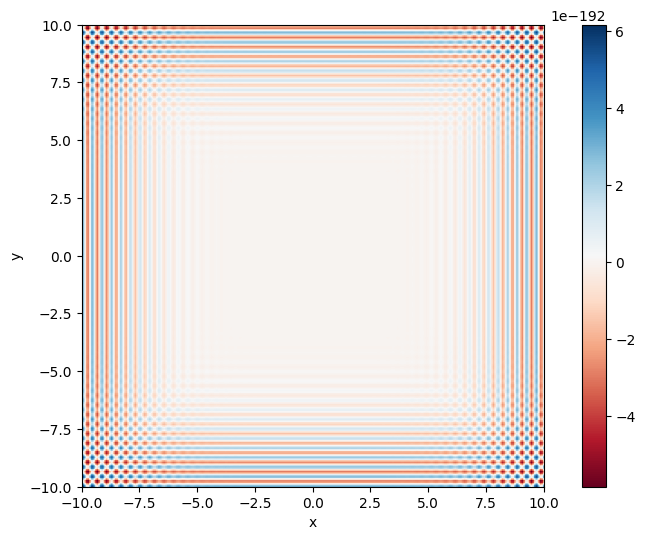

<Figure size 640x480 with 0 Axes>

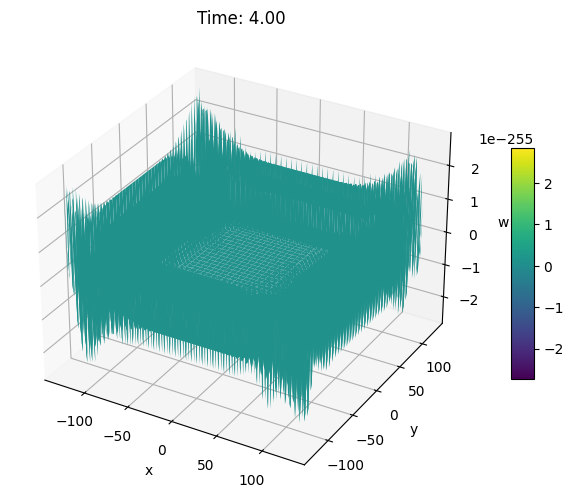

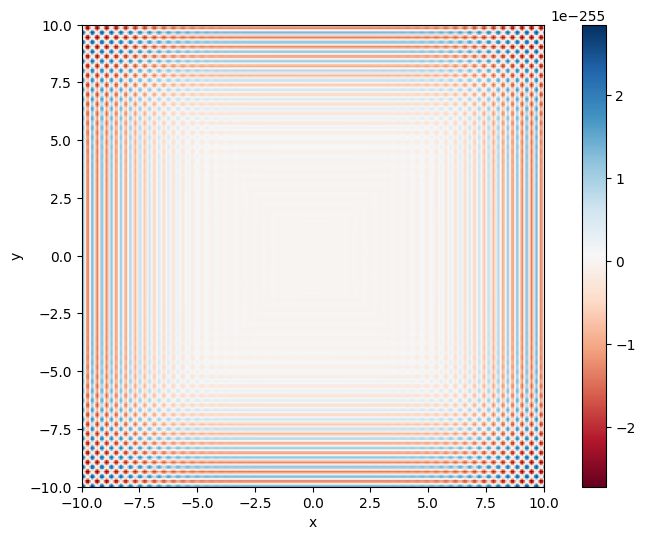

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [10]:

Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth = initialize_grid()

# Initial conditions

w = np.cos(X) + np.cos(Y)
#w = np.random.randn(Nx, Ny) * 0.1  # Initial perturbation for w
u1 = np.zeros((Nx, Ny))             # Initial displacement in x direction
u2 = np.zeros((Nx, Ny))             # Initial displacement in y direction
w_values = []                       # List to store the value of w at (10,10) over time

w, u1, u2 = enforce_periodic_boundary_conditions(w, u1, u2)

def compute_f_el(u1_tilde, u2_tilde, w_tilde):

    M11 = (2 * K_squared - KY**2) / K
    M12 = (KX * KY) / K
    M22 = (2 * K_squared - KX**2) / K
    M33 = 2 * K
    
    f_el_u1 = f_el_prefactor * (M11 * u1_tilde + M12 * u2_tilde)
    f_el_u2 = f_el_prefactor * (M12 * u1_tilde + M22 * u2_tilde)
    f_el_w = f_el_prefactor * M33 * w_tilde
    
    return f_el_u1, f_el_u2, f_el_w

def f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde):

    f_el_u1, f_el_u2, f_el_w = compute_f_el(u1_tilde, u2_tilde, w_tilde)
    w_tilde_new = - dt * f_el_w / (1 + dt * (K_fourth - gamma * K_squared))
    u1_tilde_new = - dt* f_el_u1 
    u2_tilde_new = - dt* f_el_u2
    
    return w_tilde_new, u1_tilde_new, u2_tilde_new

for step in range(steps):
    # Fourier transforms of fields
    w_tilde = fft_transform(w)
    u1_tilde = fft_transform(u1)
    u2_tilde = fft_transform(u2)
    
    w_tilde_new_f_el, u1_tilde_new_f_el, u2_tilde_new_f_el = f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde)

    w_tilde_new =  w_tilde_new_f_el
    u1_tilde_new = u1_tilde_new_f_el
    u2_tilde_new = u2_tilde_new_f_el
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 100 == 0:
        w_values.append(w[10, 10])
        
        plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w)
        
plt.figure(figsize=(10, 6))
plt.plot(range(0, steps, 100), w_values, marker='o')
plt.title('Value of w at (0,0) over time')
plt.xlabel('Time step')
plt.ylabel('w(0,0)')
plt.grid(True)
plt.show()


## Adding f_el

![title](matrix.jpg)

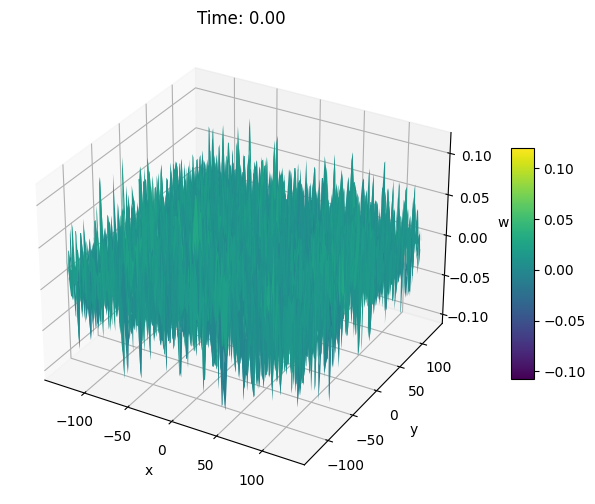

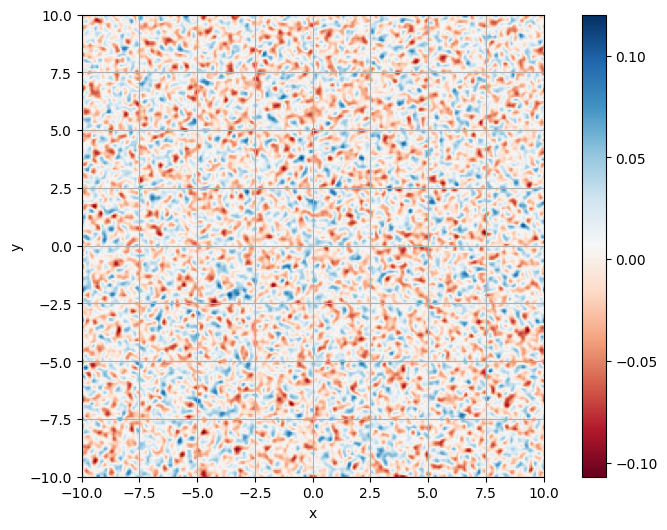

<Figure size 640x480 with 0 Axes>

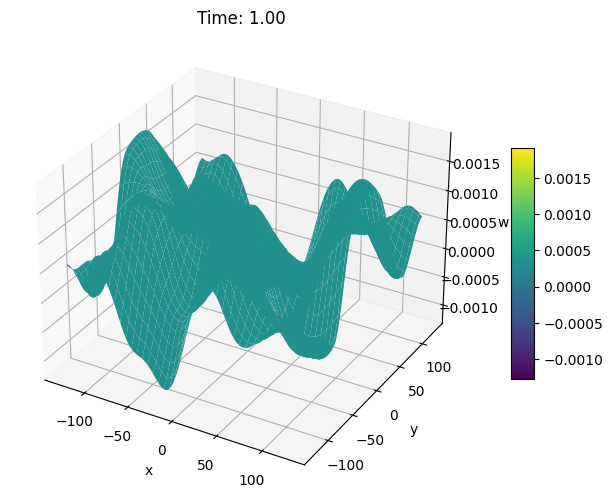

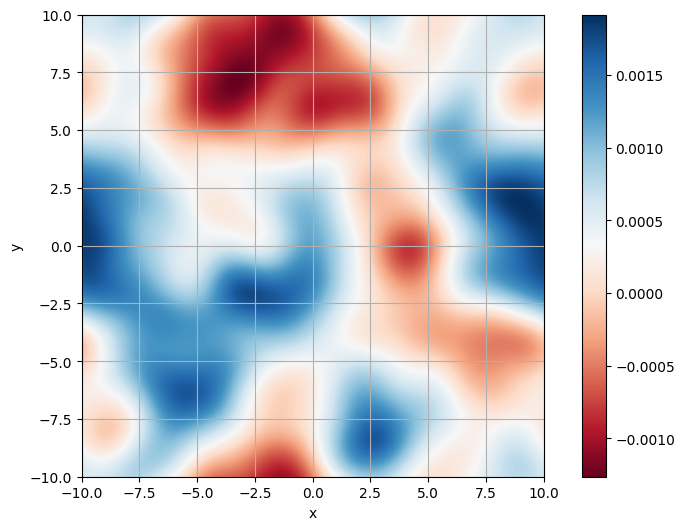

<Figure size 640x480 with 0 Axes>

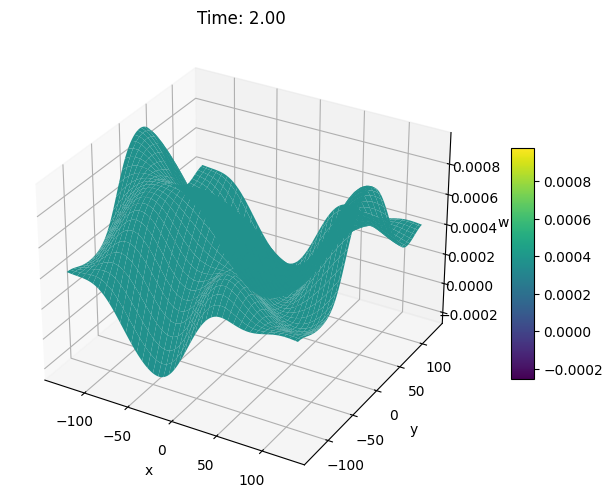

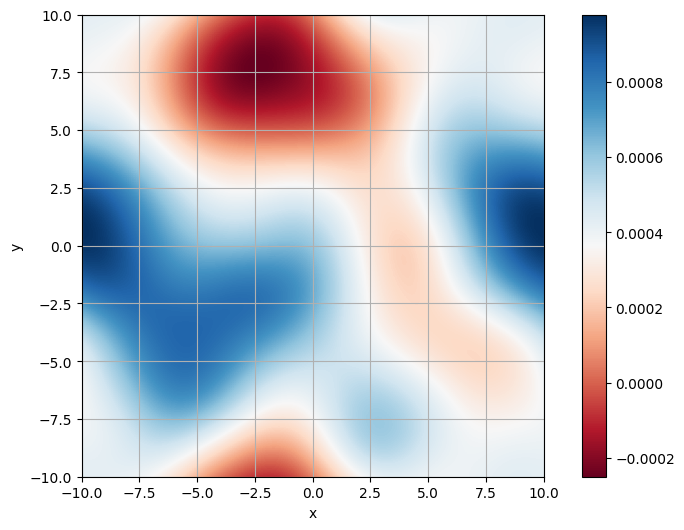

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [6]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth = initialize_grid()

# Initial conditions

#w = np.cos(X) + np.cos(Y)
w = np.random.randn(Nx, Ny) * 0.1  # Initial perturbation for w
u1 = np.zeros((Nx, Ny))             # Initial displacement in x direction
u2 = np.zeros((Nx, Ny))             # Initial displacement in y direction
w_values = []                       # List to store the value of w at (10,10) over time

w, u1, u2 = enforce_periodic_boundary_conditions(w, u1, u2)

for step in range(steps):
    # Fourier transforms of fields
    w_tilde = fft_transform(w)
    u1_tilde = fft_transform(u1)
    u2_tilde = fft_transform(u2)
    
    w_tilde_new_linear, u1_tilde_new_linear, u2_tilde_new_linear = linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    w_tilde_new_f_el, u1_tilde_new_f_el, u2_tilde_new_f_el = f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde)

    w_tilde_new = w_tilde_new_linear + w_tilde_new_f_el
    u1_tilde_new = u1_tilde_new_linear + u1_tilde_new_f_el
    u2_tilde_new = u2_tilde_new_linear + u2_tilde_new_f_el
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 100 == 0:
        w_values.append(w[10, 10])
        
        plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w)

plt.figure(figsize=(10, 6))
plt.plot(range(0, steps, 100), w_values, marker='o')
plt.title('Value of w at (0,0) over time')
plt.xlabel('Time step')
plt.ylabel('w(0,0)')
plt.grid(True)
plt.show()


## Non linear Term

In [6]:
def derivative_x(field):

    # Transform to Fourier space
    field_tilde = fft2(field)
    
    # Multiply by ikx in Fourier space to compute the derivative in x direction
    derivative_tilde = 1j * KX * field_tilde
    
    # Transform back to real space
    derivative_real = np.real(ifft2(derivative_tilde))
    
    return derivative_real

def derivative_y(field):

    # Transform to Fourier space
    field_tilde = fft2(field)
    
    # Multiply by iky in Fourier space to compute the derivative in y direction
    derivative_tilde = 1j * KY * field_tilde
    
    # Transform back to real space
    derivative_real = np.real(ifft2(derivative_tilde))
    
    return derivative_real


def compute_nonlinear_term_for_w(w, u1, u2):

    # Compute derivatives of w and u1, u2
    dw_dx = derivative_x(w)
    dw_dy = derivative_y(w)
    du1_dy = derivative_y(u1)
    du2_dx = derivative_x(u2)

    # Compute the terms within the bracket
    term_1 = dw_dy * (du1_dy + du2_dx + dw_dx * dw_dy)
    term_2 = dw_dx * (du1_dy + du2_dx + dw_dx * dw_dy)

    # Compute the derivative with respect to x_beta (x and y directions)
    d_term_1_dx = derivative_x(term_1)
    d_term_2_dy = derivative_y(term_2)

    # Combine the derivatives to get the final expression
    # This corresponds to the outer derivative with respect to x_beta, summing over both directions
    result = non_linear_prefactor * (d_term_1_dx + d_term_2_dy)
    
    return result


def compute_nonlinear_term_for_u1_u2(w, u1, u2):

    # Compute derivatives of w and u1, u2
    dw_dx = derivative_x(w)
    dw_dy = derivative_y(w)
    du1_dy = derivative_y(u1)
    du2_dx = derivative_x(u2)

    # Compute the terms within the bracket
    term = (du1_dy + du2_dx + dw_dx * dw_dy)

    # Compute the derivative with respect to x_beta (x and y directions)
    d_term_1_dx = derivative_x(term)
    d_term_2_dy = derivative_y(term)

    u1_result = non_linear_prefactor * d_term_1_dx
    u2_result = non_linear_prefactor * d_term_2_dy

    return u1_result, u2_result

In [ ]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth = initialize_grid()

# Initial conditions
w = (1 + np.cos(X) + np.cos(Y)) * 0.1
#w = np.random.randn(Nx, Ny) * 0.1  # Initial perturbation for w
u1 = np.random.randn(Nx, Ny) * 0.1            # Initial displacement in x direction
u2 = np.random.randn(Nx, Ny) * 0.1             # Initial displacement in y direction
w_values = []

w, u1, u2 = enforce_periodic_boundary_conditions(w, u1, u2)

def non_linear_first_order_scheme(w, u1, u2):

    w_non_linear = compute_nonlinear_term_for_w(w, u1, u2)
    u1_non_linear, u2_non_linear = compute_nonlinear_term_for_u1_u2(w, u1, u2)

    w_non_linear_tilde = fft_transform(w_non_linear)
    u1_non_linear_tilde = fft_transform(u1_non_linear)
    u2_non_linear_tilde = fft_transform(u2_non_linear)

    w_tilde_new =  dt * w_non_linear_tilde / (1 + dt * (K_fourth - gamma * K_squared))
    u1_tilde_new = dt * u1_non_linear_tilde
    u2_tilde_new = dt * u2_non_linear_tilde
    
    return w_tilde_new, u1_tilde_new, u2_tilde_new

for step in range(steps):

    # Fourier transforms of fields
    w_tilde = fft_transform(w)
    u1_tilde = fft_transform(u1)
    u2_tilde = fft_transform(u2)
    

    w_tilde_new_non_linear, u1_tilde_new_non_linear, u2_tilde_new_non_linear = non_linear_first_order_scheme(w, u1, u2)

    w_tilde_new = w_tilde_new_non_linear
    u1_tilde_new = u1_tilde_new_non_linear
    u2_tilde_new = u2_tilde_new_non_linear
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 100 == 0:

        w_values.append(w[10, 10])
        #print(w_tilde_new_non_linear/w_tilde_new_f_el)

        plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w)
    

plt.figure(figsize=(10, 6))
plt.plot(range(0, steps, 100), w_values, marker='o')
plt.title('Value of w at (0,0) over time')
plt.xlabel('Time step')
plt.ylabel('w(0,0)')
plt.grid(True)
plt.show()


## Adding non linear term

![title](equations.jpg)

In [ ]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth = initialize_grid()

# Initial conditions
#w = (1 + np.cos(X) + np.cos(Y)) * 0.1
w = np.random.randn(Nx, Ny) * 0.1  # Initial perturbation for w
u1 = np.random.randn(Nx, Ny) * 0.1            # Initial displacement in x direction
u2 = np.random.randn(Nx, Ny) * 0.1             # Initial displacement in y direction
w_values = []

w, u1, u2 = enforce_periodic_boundary_conditions(w, u1, u2)

def non_linear_first_order_scheme(w, u1, u2):

    w_non_linear = compute_nonlinear_term_for_w(w, u1, u2)
    u1_non_linear, u2_non_linear = compute_nonlinear_term_for_u1_u2(w, u1, u2)

    w_non_linear_tilde = fft_transform(w_non_linear)
    u1_non_linear_tilde = fft_transform(u1_non_linear)
    u2_non_linear_tilde = fft_transform(u2_non_linear)

    w_tilde_new =  dt * w_non_linear_tilde / (1 + dt * (K_fourth - gamma * K_squared))
    u1_tilde_new = dt * u1_non_linear_tilde
    u2_tilde_new = dt * u2_non_linear_tilde
    
    return w_tilde_new, u1_tilde_new, u2_tilde_new

for step in range(steps):

    # Fourier transforms of fields
    w_tilde = fft_transform(w)
    u1_tilde = fft_transform(u1)
    u2_tilde = fft_transform(u2)
    

    w_tilde_new_linear, u1_tilde_new_linear, u2_tilde_new_linear = linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    w_tilde_new_f_el, u1_tilde_new_f_el, u2_tilde_new_f_el = f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    w_tilde_new_non_linear, u1_tilde_new_non_linear, u2_tilde_new_non_linear = non_linear_first_order_scheme(w, u1, u2)

    w_tilde_new = w_tilde_new_linear + w_tilde_new_f_el + w_tilde_new_non_linear
    u1_tilde_new = u1_tilde_new_linear + u1_tilde_new_f_el + u1_tilde_new_non_linear
    u2_tilde_new = u2_tilde_new_linear + u2_tilde_new_f_el + u2_tilde_new_non_linear
    
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 100 == 0:

        w_values.append(w[10, 10])
        #print(w_tilde_new_non_linear/w_tilde_new_f_el)

        plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w)
    

plt.figure(figsize=(10, 6))
plt.plot(range(0, steps, 100), w_values, marker='o')
plt.title('Value of w at (0,0) over time')
plt.xlabel('Time step')
plt.ylabel('w(0,0)')
plt.grid(True)
plt.show()


## Testing

In [ ]:
# Parameters for the domain
Lx, Ly = 100.0, 100.0   # Domain size in x and y directions
Nx, Ny = 128, 128       # Number of grid points in x and y
dx, dy = Lx/Nx, Ly/Ny   # Grid spacing
dt = 0.01               # Time step size
total_time = 5.0        # Total simulation time
steps = int(total_time / dt)

# Create spatial grid
x = np.linspace(0, Lx, Nx, endpoint=False)
y = np.linspace(0, Ly, Ny, endpoint=False)
X, Y = np.meshgrid(x, y)

# Wavenumber grids in Fourier space
kx = 2 * np.pi * fftfreq(Nx, d=dx)
ky = 2 * np.pi * fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky)

K_squared = KX**2 + KY**2
K = np.sqrt(K_squared)
K_fourth = K_squared**2

# Handling division by zero at k=0
K[K == 0] = 1e-10

# Initial conditions
w = np.random.randn(Nx, Ny) * 0.1  # Initial perturbation for w
u1 = np.zeros((Nx, Ny))             # Initial displacement in x direction
u2 = np.zeros((Nx, Ny))             # Initial displacement in y direction
w_values = []


def compute_f_el(u1_tilde, u2_tilde, w_tilde):
    
    M11 = (2 * K_squared - KY**2) / K
    M12 = (KX * KY) / K
    M22 = (2 * K_squared - KX**2) / K
    M33 = 2 * K
    
    f_el_u1 = f_el_prefactor * (M11 * u1_tilde + M12 * u2_tilde)
    f_el_u2 = f_el_prefactor * (M12 * u1_tilde + M22 * u2_tilde)
    f_el_w = f_el_prefactor * M33 * w_tilde
    
    return f_el_u1, f_el_u2, f_el_w

def f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde):

    f_el_u1, f_el_u2, f_el_w = compute_f_el(u1_tilde, u2_tilde, w_tilde)
    w_tilde_new = - dt * f_el_w / (1 + dt * (K_fourth - gamma * K_squared))
    u1_tilde_new = - dt* f_el_u1 
    u2_tilde_new = - dt* f_el_u2
    
    return w_tilde_new, u1_tilde_new, u2_tilde_new

# Time stepping loop
w_tilde_prev, u1_tilde_prev, u2_tilde_prev = None, None, None

for step in range(steps):
    # Fourier transforms of fields
    w_tilde = fft_transform(w)
    u1_tilde = fft_transform(u1)
    u2_tilde = fft_transform(u2)
    
    # First two iterations using first-order semi-implicit scheme
 #   if step < 2:
        # Update w using the first order scheme with nonlinear term

    w_tilde_new_linear, u1_tilde_new_linear, u2_tilde_new_linear = linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    w_tilde_new_f_el, u1_tilde_new_f_el, u2_tilde_new_f_el = f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde)

    w_tilde_new = w_tilde_new_linear + w_tilde_new_f_el
    u1_tilde_new = u1_tilde_new_linear + u1_tilde_new_f_el
    u2_tilde_new = u2_tilde_new_linear + u2_tilde_new_f_el
    
    # # Use second-order BDF/AB scheme after the first two iterations
    # else:
    #     w_tilde_new = second_order_scheme(w_tilde, w_tilde_prev, f_el_w, f_el_w_prev, evolution_factor_w)
    #     u1_tilde_new = second_order_scheme(u1_tilde, u1_tilde_prev, f_el_u1, f_el_u1_prev, evolution_factor_u)
    #     u2_tilde_new = second_order_scheme(u2_tilde, u2_tilde_prev, f_el_u2, f_el_u2_prev, evolution_factor_u)
    
    # Store previous iterations for next step
    # w_tilde_prev, f_el_w_prev = w_tilde, f_el_w
    # u1_tilde_prev, f_el_u1_prev = u1_tilde, f_el_u1
    # u2_tilde_prev, f_el_u2_prev = u2_tilde, f_el_u2
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 100 == 0:
        w_values.append(w[10, 10])
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        # Set the limits for the z-axis to keep the scale constant
        ax.set_zlim(-0.2, 0.2)
        # Plot the surface
        surface = ax.plot_surface(X, Y, w, cmap='viridis', vmin=-0.2, vmax=0.2)
        ax.set_title(f'Time: {step * dt:.2f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('w')
        
        # # Set the limits for the z-axis to keep the scale constant
        # ax.set_zlim(-0.2, 0.2)

        # Add a colorbar
        mappable = plt.cm.ScalarMappable(cmap='viridis')
        mappable.set_array(w)
        plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
        
        # Show the plot
        plt.show()

        plt.imshow(w, extent=(0, Lx, 0, Ly), origin='lower', cmap='RdBu')
        plt.colorbar()
        plt.title(f'Time: {step * dt:.2f}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.pause(0.1)
        plt.clf()
    

plt.figure(figsize=(10, 6))
plt.plot(range(0, steps, 100), w_values, marker='o')
plt.title('Value of w at (0,0) over time')
plt.xlabel('Time step')
plt.ylabel('w(0,0)')
plt.grid(True)
plt.show()


In [ ]:
# Parameters for the domain
Lx, Ly = 100.0, 100.0   # Domain size in x and y directions
Nx, Ny = 128, 128       # Number of grid points in x and y
dx, dy = Lx/Nx, Ly/Ny   # Grid spacing
dt = 0.01               # Time step size
total_time = 5.0        # Total simulation time
steps = int(total_time / dt)

# Create spatial grid
x = np.linspace(0, Lx, Nx, endpoint=False)
y = np.linspace(0, Ly, Ny, endpoint=False)
X, Y = np.meshgrid(x, y)

# Wavenumber grids in Fourier space
kx = 2 * np.pi * fftfreq(Nx, d=dx)
ky = 2 * np.pi * fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky)

K_squared = KX**2 + KY**2
K = np.sqrt(K_squared)
K_fourth = K_squared**2

# Handling division by zero at k=0
K[K == 0] = 1e-10

# Initial conditions

w = np.cos(X) + np.cos(Y)
# w = np.random.randn(Nx, Ny)  # Initial perturbation for w
u1 = np.zeros((Nx, Ny))             # Initial displacement in x direction
u2 = np.zeros((Nx, Ny))             # Initial displacement in y direction
w_values = []                       # List to store the value of w at (10,10) over time

w, u1, u2 = enforce_periodic_boundary_conditions(w, u1, u2)

def compute_f_el(u1_tilde, u2_tilde, w_tilde):

    M11 = (2 * K_squared - KY**2) / K
    M12 = (KX * KY) / K
    M22 = (2 * K_squared - KX**2) / K
    M33 = 2 * K
    
    f_el_u1 = f_el_prefactor * (M11 * u1_tilde + M12 * u2_tilde)
    f_el_u2 = f_el_prefactor * (M12 * u1_tilde + M22 * u2_tilde)
    f_el_w = f_el_prefactor * M33 * w_tilde
    
    return f_el_u1, f_el_u2, f_el_w

def f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde):

    f_el_u1, f_el_u2, f_el_w = compute_f_el(u1_tilde, u2_tilde, w_tilde)
    w_tilde_new = - dt * f_el_w / (1 + dt * (K_fourth - gamma * K_squared))
    u1_tilde_new = - dt* f_el_u1 
    u2_tilde_new = - dt* f_el_u2
    
    return w_tilde_new, u1_tilde_new, u2_tilde_new

for step in range(steps):
    # Fourier transforms of fields
    w_tilde = fft_transform(w)
    u1_tilde = fft_transform(u1)
    u2_tilde = fft_transform(u2)
    
    w_tilde_new_f_el, u1_tilde_new_f_el, u2_tilde_new_f_el = f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde)

    w_tilde_new = w_tilde_new_f_el
    u1_tilde_new = u1_tilde_new_f_el
    u2_tilde_new = u2_tilde_new_f_el
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 100 == 0:
        w_values.append(w[10, 10])
        
        
        plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w)
    

plt.figure(figsize=(10, 6))
plt.plot(range(0, steps, 100), w_values, marker='o')
plt.title('Value of w at (0,0) over time')
plt.xlabel('Time step')
plt.ylabel('w(0,0)')
plt.grid(True)
plt.show()
